In [1]:
import torch
import numpy as np
from torch import nn
import random
import torch.nn.functional as F
import collections
from torch.optim.lr_scheduler import StepLR
# from CommunicationP3DX import CommunicationP3DX
# from Agent import AgentClass
# from std_srvs.srv import Empty
# import rospy
import time
import shelve
import os
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def get_complete_hist_from_shelve(workspace_folder_path, agg_method, n_sectors):
    return shelve.open(workspace_folder_path+'/wsh_{metodo}{n_setores}completo.out'.format(
        metodo = agg_method,n_setores = n_sectors
    ))['hist_dict']

def get_rewards_df(hist_dict,method):
    rewards = []
    episodes = []
    for key in hist_dict['rewards'].keys():
        episodes.append(key)
        rewards.append(hist_dict['rewards_eval'][key][0])
    return pd.DataFrame({'Episodes':episodes, 'Rewards'+method:rewards})

def get_distances_df(hist_dict, method):
    distances = []
    episodes = []
    for key in hist_dict['rewards'].keys():
        episodes.append(key)
        distances.append(hist_dict['rewards_eval'][key][1])
    return pd.DataFrame({'Episodes':episodes, 'Distances'+method:distances})

# 0 for crash, 1 for goal 2 for time
def get_success_df(hist_dict,method):
    success = []
    episodes = []
    for key in hist_dict['epresult'].keys():
        episodes.append(key)
        success.append(hist_dict['epresult'][key][1])
    df = pd.DataFrame({'Episodes':episodes, 'Success'+method:success})
    df['Success'+method] = np.where(df['Success'+method]==1,1,0)
    return df

def get_collision_df(hist_dict,method):
    collision = []
    episodes = []
    for key in hist_dict['epresult'].keys():
        episodes.append(key)
        collision.append(int(np.where(hist_dict['epresult'][key][1]==0,1,0)))
    df = pd.DataFrame({'Episodes':episodes, 'Collision'+method:collision})
    return df

# get hists by method
workspace_folder_path = '/media/xnd/7A309A87309A49D1/sia_23/25k/'
#  'C:/Users/alexa/Desktop/sia_DRL_2023/25k/'

training_list = [
    ['mean','4']
    ,['mean','5']
    ,['mean','6']
    ,['mean','10']
    ,['min','4']
    ,['min','5']
    ,['min','6']
    ,['min','10']
    ]

# results_dfs = {}
# for agg_method, n_sectors in training_list:
#     print('Processing: {agg_method}-{n_sectors}'.format(agg_method=agg_method,  n_sectors=n_sectors))
#     hist = get_complete_hist_from_shelve(workspace_folder_path, agg_method, n_sectors)

#     results_dfs[agg_method+'_'+n_sectors] = {
#         'rewards_df':get_rewards_df(hist, method=agg_method),
#         'distances_df':get_distances_df(hist, method=agg_method),
#         'success_df':get_success_df(hist, method=agg_method),
#         'collisions_df':get_collision_df(hist, method=agg_method)

#     }
    
#     del hist

# import pickle
# with open('mean_min_25k_results_dfs.pickle', 'wb') as handle:
#     pickle.dump(results_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
df_results = pd.read_pickle('dataset_large_vae_mean-6.pickle')
print(len(df_results.index))
df_results.head(3)

170569


,x,y,scan_0,scan_1,scan_2,scan_3,scan_4,scan_5,scan_6,scan_7,...,scan_717,scan_718,scan_719,scan_720,scan_721,scan_722,scan_723,scan_724,scan_725,scan_726
0,-3.597518,1.868292,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1.797938,1.836887,1.893012,1.932175,1.97115,2.017838,2.080064,2.125983,2.204508,2.232049
1,-3.058294,1.677012,1.598871,1.566499,1.564023,1.578760,1.571751,1.573053,1.561763,1.547100,...,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
2,-2.680388,2.161795,3.006377,3.000700,2.982186,2.960687,2.977025,2.961803,2.946075,2.947741,...,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000


<AxesSubplot: xlabel='yd', ylabel='Count'>

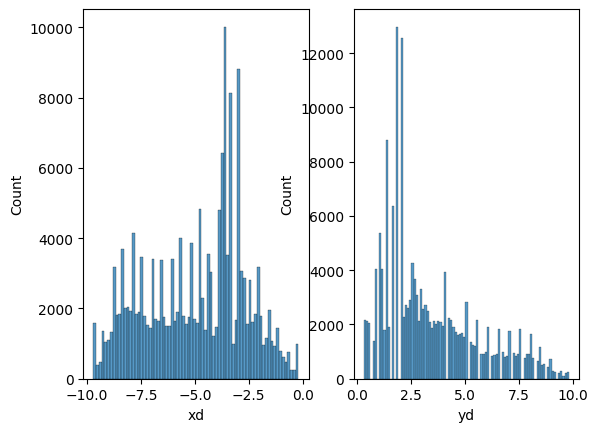

In [4]:
df_htmp = df_results.copy()
df_htmp['xd'] = [int(10*val) for val in df_htmp['x'].values]
df_htmp['yd'] = [int(10*val) for val in df_htmp['y'].values]

# df_htmp['xd'].apply(lambda x : np.NaN if x ==-4 else x)
plt.subplot(121)
sns.histplot(df_htmp['xd']/10)
plt.subplot(122)
sns.histplot(df_htmp['yd']/10)

# df_htmp['xd'] = df_htmp['xd']==-2;

# sns.jointplot(x=df_htmp['xd']/10, y=df_htmp['yd']/10, kind="hex")#, color="#4CB391")
# sns.set_theme(style="white")
# g = sns.JointGrid(data=df_htmp, x="xd", y="yd", space=0)
# g.plot_joint(sns.kdeplot,
#              fill=True, clip=((2200, 6800), (10, 25)),
#              thresh=0, levels=100, cmap="rocket")
# g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

<AxesSubplot: >

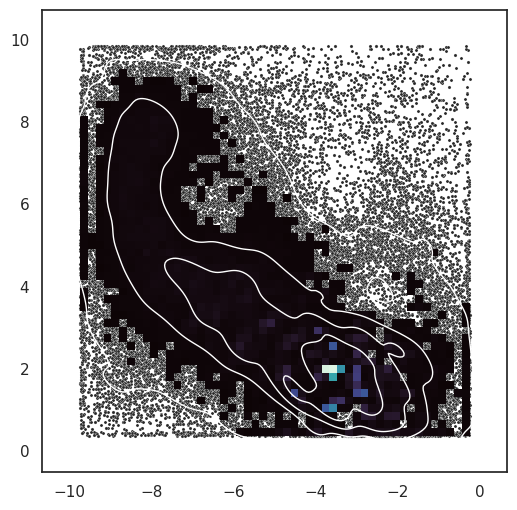

In [6]:
def transf(val): return val


x  = [transf(val) for val in df_htmp['x'].values]
y = [transf(val) for val in df_htmp['y'].values]
# Draw a combo histogram and scatterplot with density contours
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

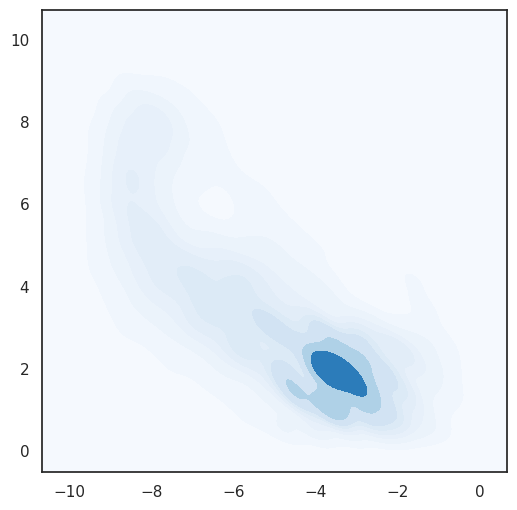

In [12]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=.5, color="tab:blue", alpha = 0.3, ax = ax)
sns.kdeplot(x = x, y = y, fill=True, thresh=0, cmap='Blues', ax = ax);
# sns.jointplot(x = x, y = y, kind = "kde" , space=0, fill=True, thresh=0, cmap='Blues', ax = ax);